# **Random Forest Training & Evaluation Pipeline** 

This notebook automates data loading, preprocessing, model training with hyperparameter tuning, evaluation, and basic visualizations for our Heron WellNest project.

---

## **Setup and Imports**

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.feature_selection import f_classif, mutual_info_classif
import seaborn as sns
from sklearn.decomposition import PCA
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter

---
## **Configurations**


In [2]:
DATA_PATH = '../../data/classification/synthetic_dataset.csv'
# Path where the trained model will be saved
MODEL_PATH = '../../models/classification/random_forest.joblib'

---
## **Load Data**


In [3]:
df = pd.read_csv(DATA_PATH)

target_col = 'WellbeingClass'

labels = df[target_col].unique()
feature_cols = ["p_anxiety", "p_normal", "p_depression", "p_suicidal", "p_stress", "gratitude_flag",
                "Depressed","Sad","Exhausted","Hopeless","Anxious",
                "Angry","Stressed","Restless","Calm","Relaxed",
                "Peaceful","Content","Happy","Energized","Excited",'Motivated']

print(df[target_col].value_counts())
df.head()

WellbeingClass
Struggling    3751
Thriving      2697
InCrisis      2662
Excelling      890
Name: count, dtype: int64


,p_anxiety,p_normal,p_depression,p_suicidal,p_stress,gratitude_flag,WellbeingClass,Depressed,Sad,Exhausted,...,Stressed,Restless,Calm,Relaxed,Peaceful,Content,Happy,Energized,Excited,Motivated
0,0.150981,0.188526,0.315104,0.132712,0.212678,0,Struggling,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,1,Excelling,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,1,Thriving,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,0.269491,0.160440,0.191467,0.151847,0.226755,0,Struggling,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0,InCrisis,0,1,0,...,0,0,0,0,0,0,0,0,0,0


----
## **Data visualization**


### **1. Target Distribution**


C:\Users\PC\AppData\Local\Temp\ipykernel_32180\1134603404.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_col, data=df, palette="Set2")


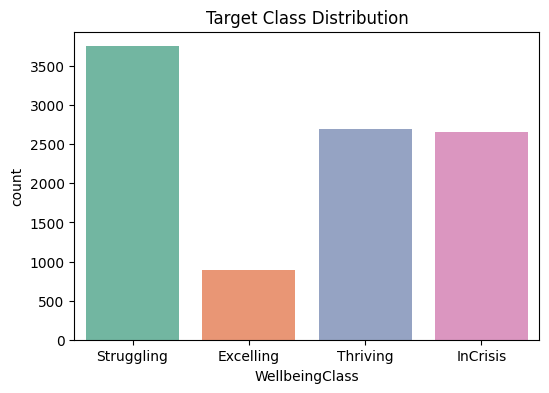

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df, palette="Set2")
plt.title("Target Class Distribution")
plt.show()

### **2. Feature Distributions per Class**


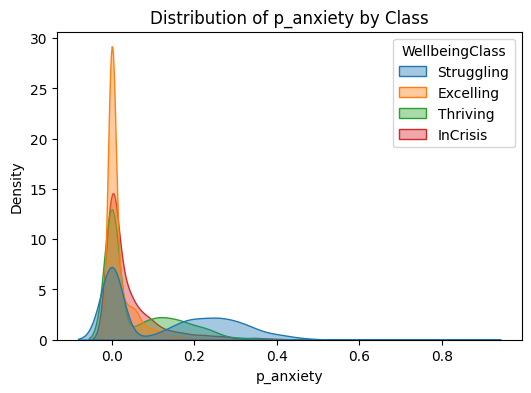

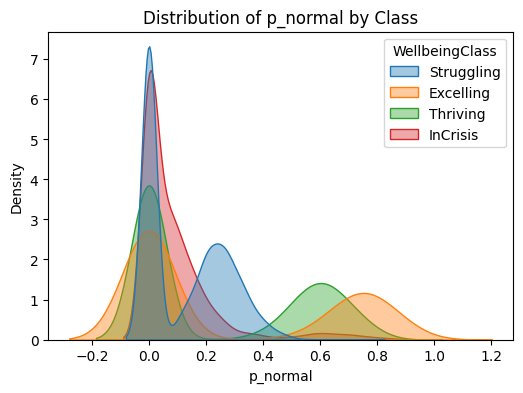

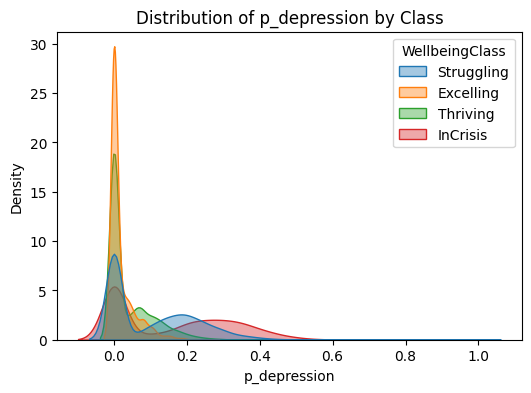

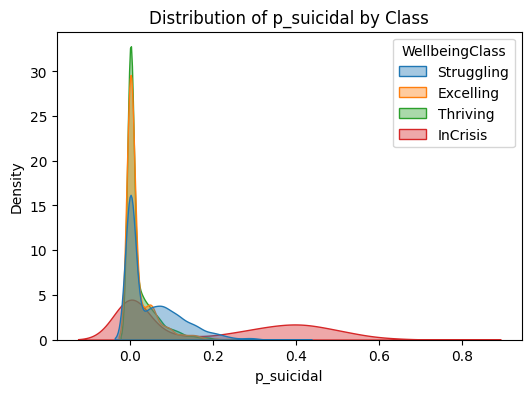

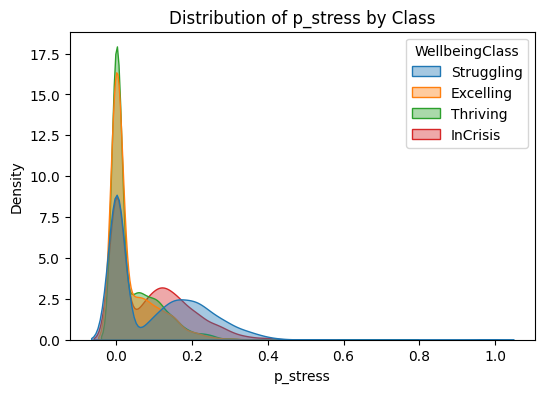

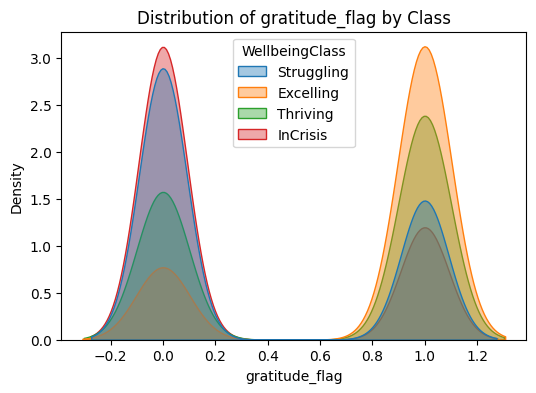

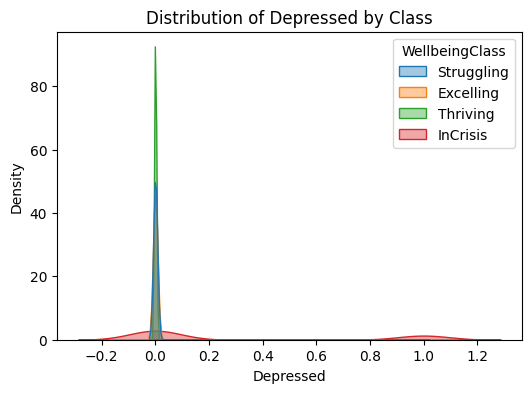

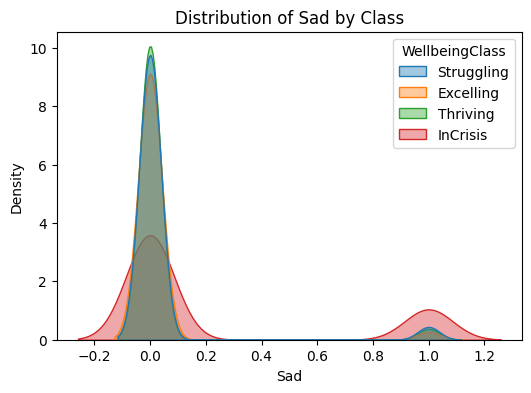

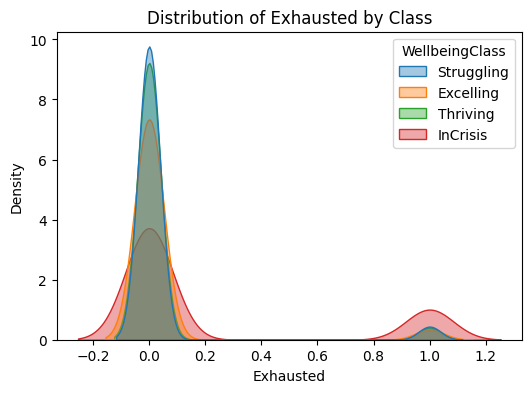

C:\Users\PC\AppData\Local\Temp\ipykernel_32180\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


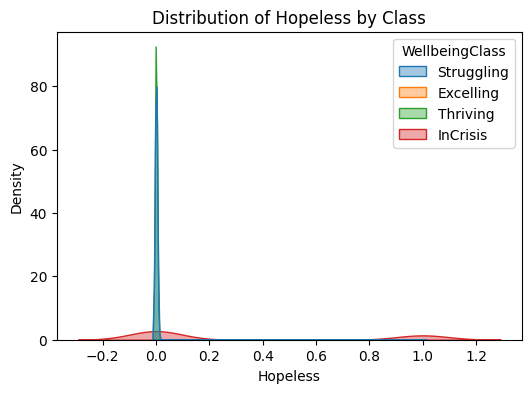

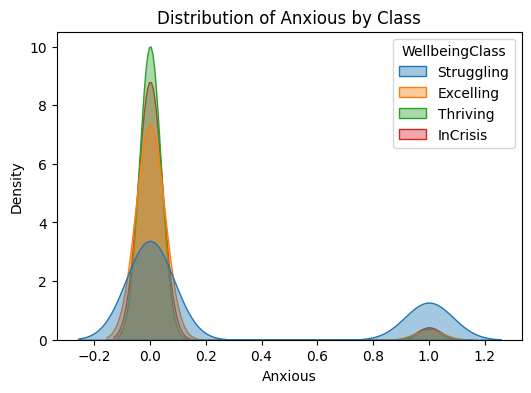

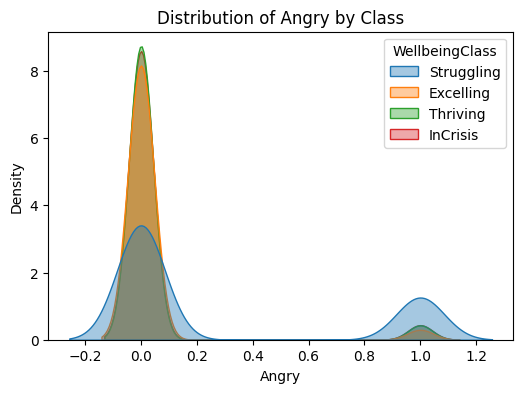

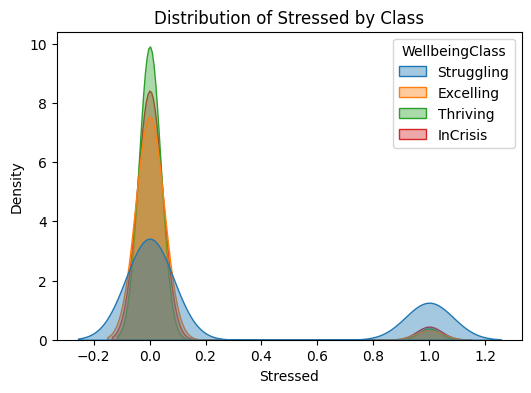

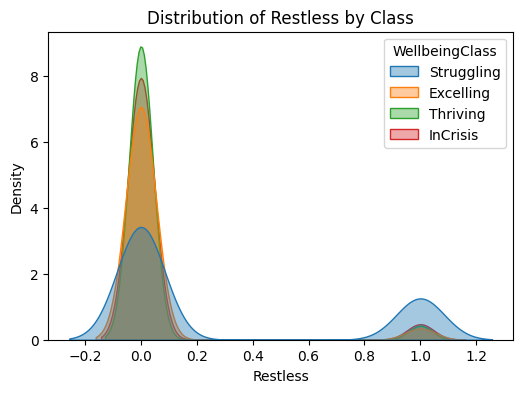

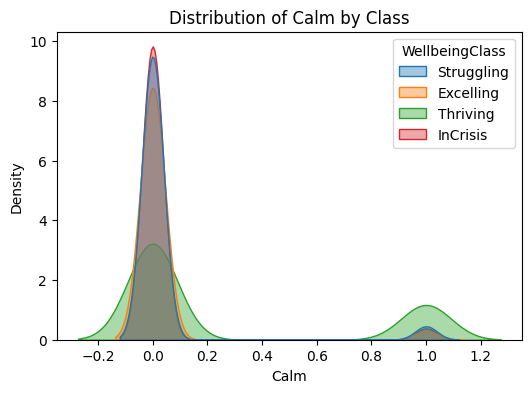

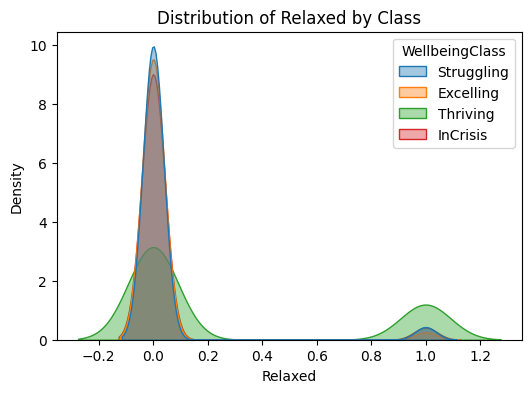

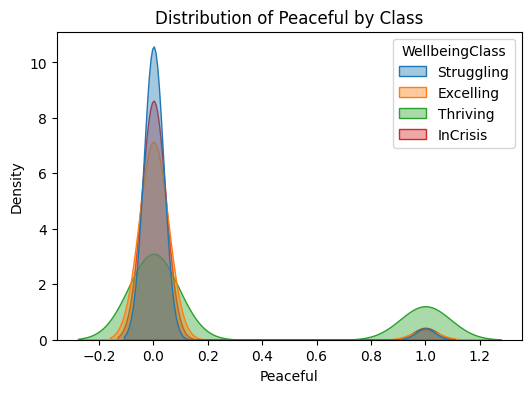

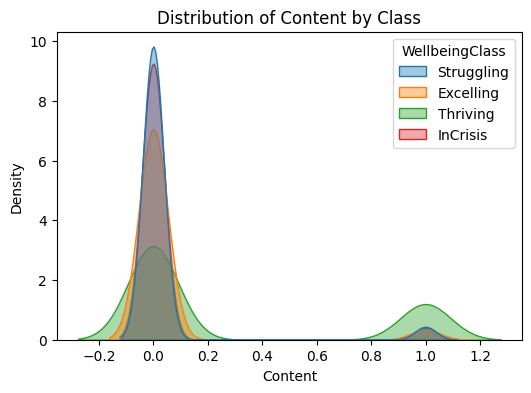

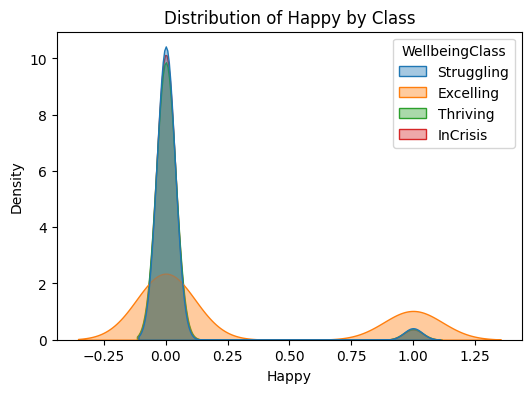

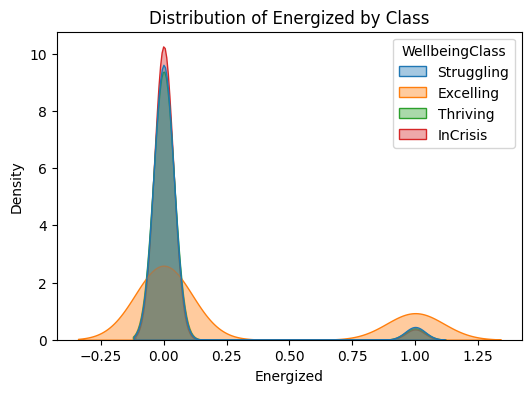

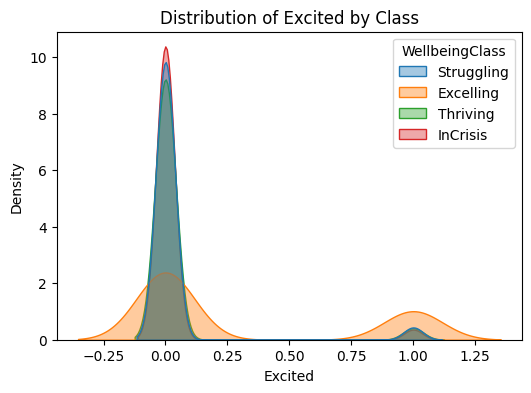

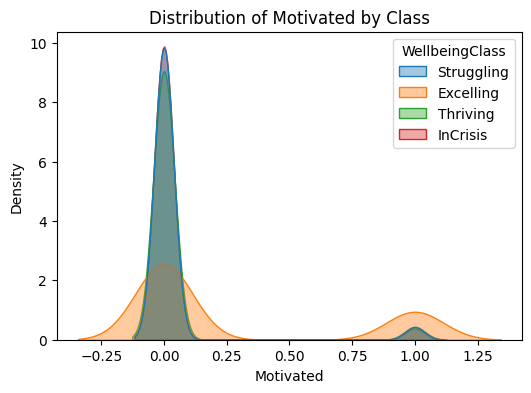

In [5]:
for col in feature_cols:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)
    plt.title(f"Distribution of {col} by Class")
    plt.show()

### **3. Feature-Feature Correlation Heatmap**


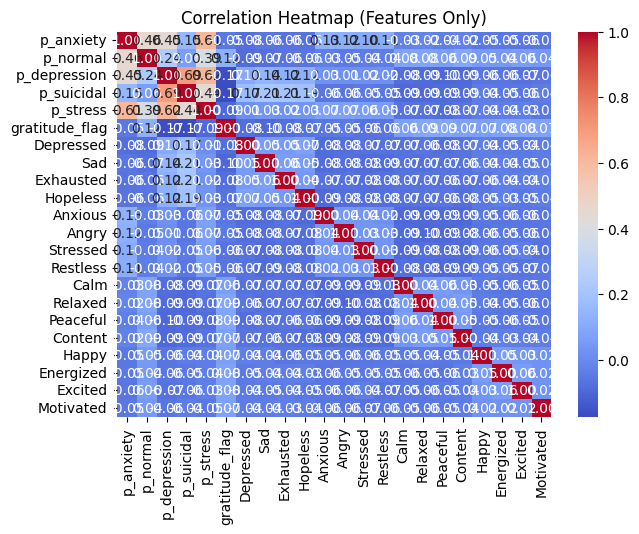

In [6]:
plt.figure(figsize=(7,5))
corr = df[feature_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Features Only)")
plt.show()

### **4. Feature-Target Correlation (via encoding)**


In [7]:
le_temp = LabelEncoder()
y_encoded = le_temp.fit_transform(df[target_col])

corr_with_target = df[feature_cols].apply(lambda x: x.corr(pd.Series(y_encoded)))
print("\n🔎 Correlation of each feature with target:\n", corr_with_target)


🔎 Correlation of each feature with target:
 p_anxiety         0.142756
p_normal          0.098021
p_depression     -0.158579
p_suicidal       -0.284179
p_stress         -0.061909
gratitude_flag    0.047321
Depressed        -0.267850
Sad              -0.151770
Exhausted        -0.142546
Hopeless         -0.277514
Anxious           0.039547
Angry             0.052017
Stressed          0.037542
Restless          0.038536
Calm              0.262984
Relaxed           0.268570
Peaceful          0.256841
Content           0.257818
Happy            -0.193162
Energized        -0.156705
Excited          -0.175815
Motivated        -0.158166
dtype: float64


### **5. ANOVA F-test (Feature importance vs target)**


📊 Feature Separability Scores:

           Feature      F-value        p-value  Mutual Information
3       p_suicidal  1256.412134   0.000000e+00            0.235233
9         Hopeless  1225.063536   0.000000e+00            0.128060
6        Depressed  1102.190564   0.000000e+00            0.119385
2     p_depression   604.699340   0.000000e+00            0.175107
0        p_anxiety   483.468794  2.273605e-293            0.196879
5   gratitude_flag   457.450192  1.580432e-278            0.073537
16        Peaceful   447.416236  8.904989e-273            0.051626
15         Relaxed   441.485853  2.268342e-269            0.051999
17         Content   426.988804  5.063282e-261            0.054711
10         Anxious   425.042828  6.722583e-260            0.054180
14            Calm   410.005961  3.353273e-251            0.047326
12        Stressed   399.540813  3.975891e-245            0.054955
11           Angry   387.988233  2.109615e-238            0.050350
18           Happy   376.0237

C:\Users\PC\AppData\Local\Temp\ipykernel_32180\2732673541.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F-value", y="Feature", data=feat_scores, ax=axes[0], palette="viridis")
C:\Users\PC\AppData\Local\Temp\ipykernel_32180\2732673541.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Mutual Information", y="Feature", data=feat_scores.sort_values("Mutual Information", ascending=False), ax=axes[1], palette="magma")


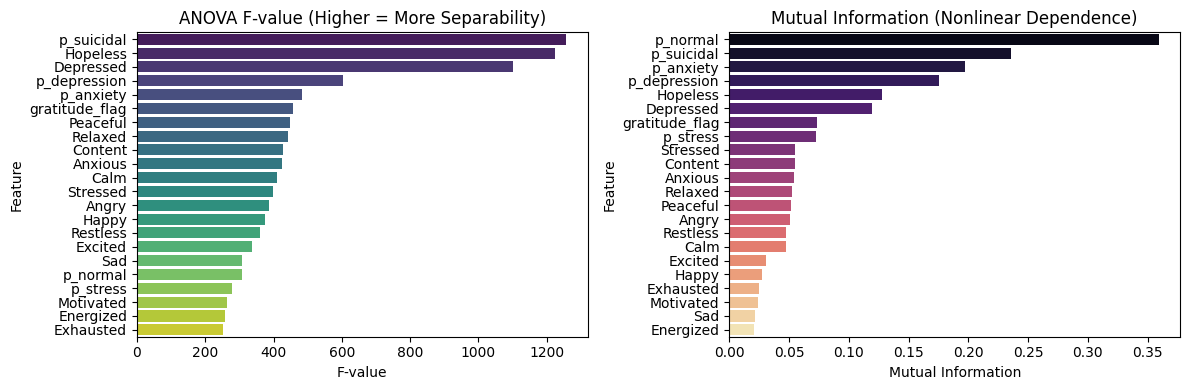

In [8]:
f_vals, p_vals = f_classif(df[feature_cols], y_encoded)
mi_vals = mutual_info_classif(df[feature_cols], y_encoded, random_state=42)

feat_scores = pd.DataFrame({
    "Feature": feature_cols,
    "F-value": f_vals,
    "p-value": p_vals,
    "Mutual Information": mi_vals
}).sort_values("F-value", ascending=False)

print("\n📊 Feature Separability Scores:\n")
print(feat_scores)

# --- Plot F-test and MI as bar chart ---
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.barplot(x="F-value", y="Feature", data=feat_scores, ax=axes[0], palette="viridis")
axes[0].set_title("ANOVA F-value (Higher = More Separability)")

sns.barplot(x="Mutual Information", y="Feature", data=feat_scores.sort_values("Mutual Information", ascending=False), ax=axes[1], palette="magma")
axes[1].set_title("Mutual Information (Nonlinear Dependence)")

plt.tight_layout()
plt.show()

### **6. Pairplot (Scatter matrix)**

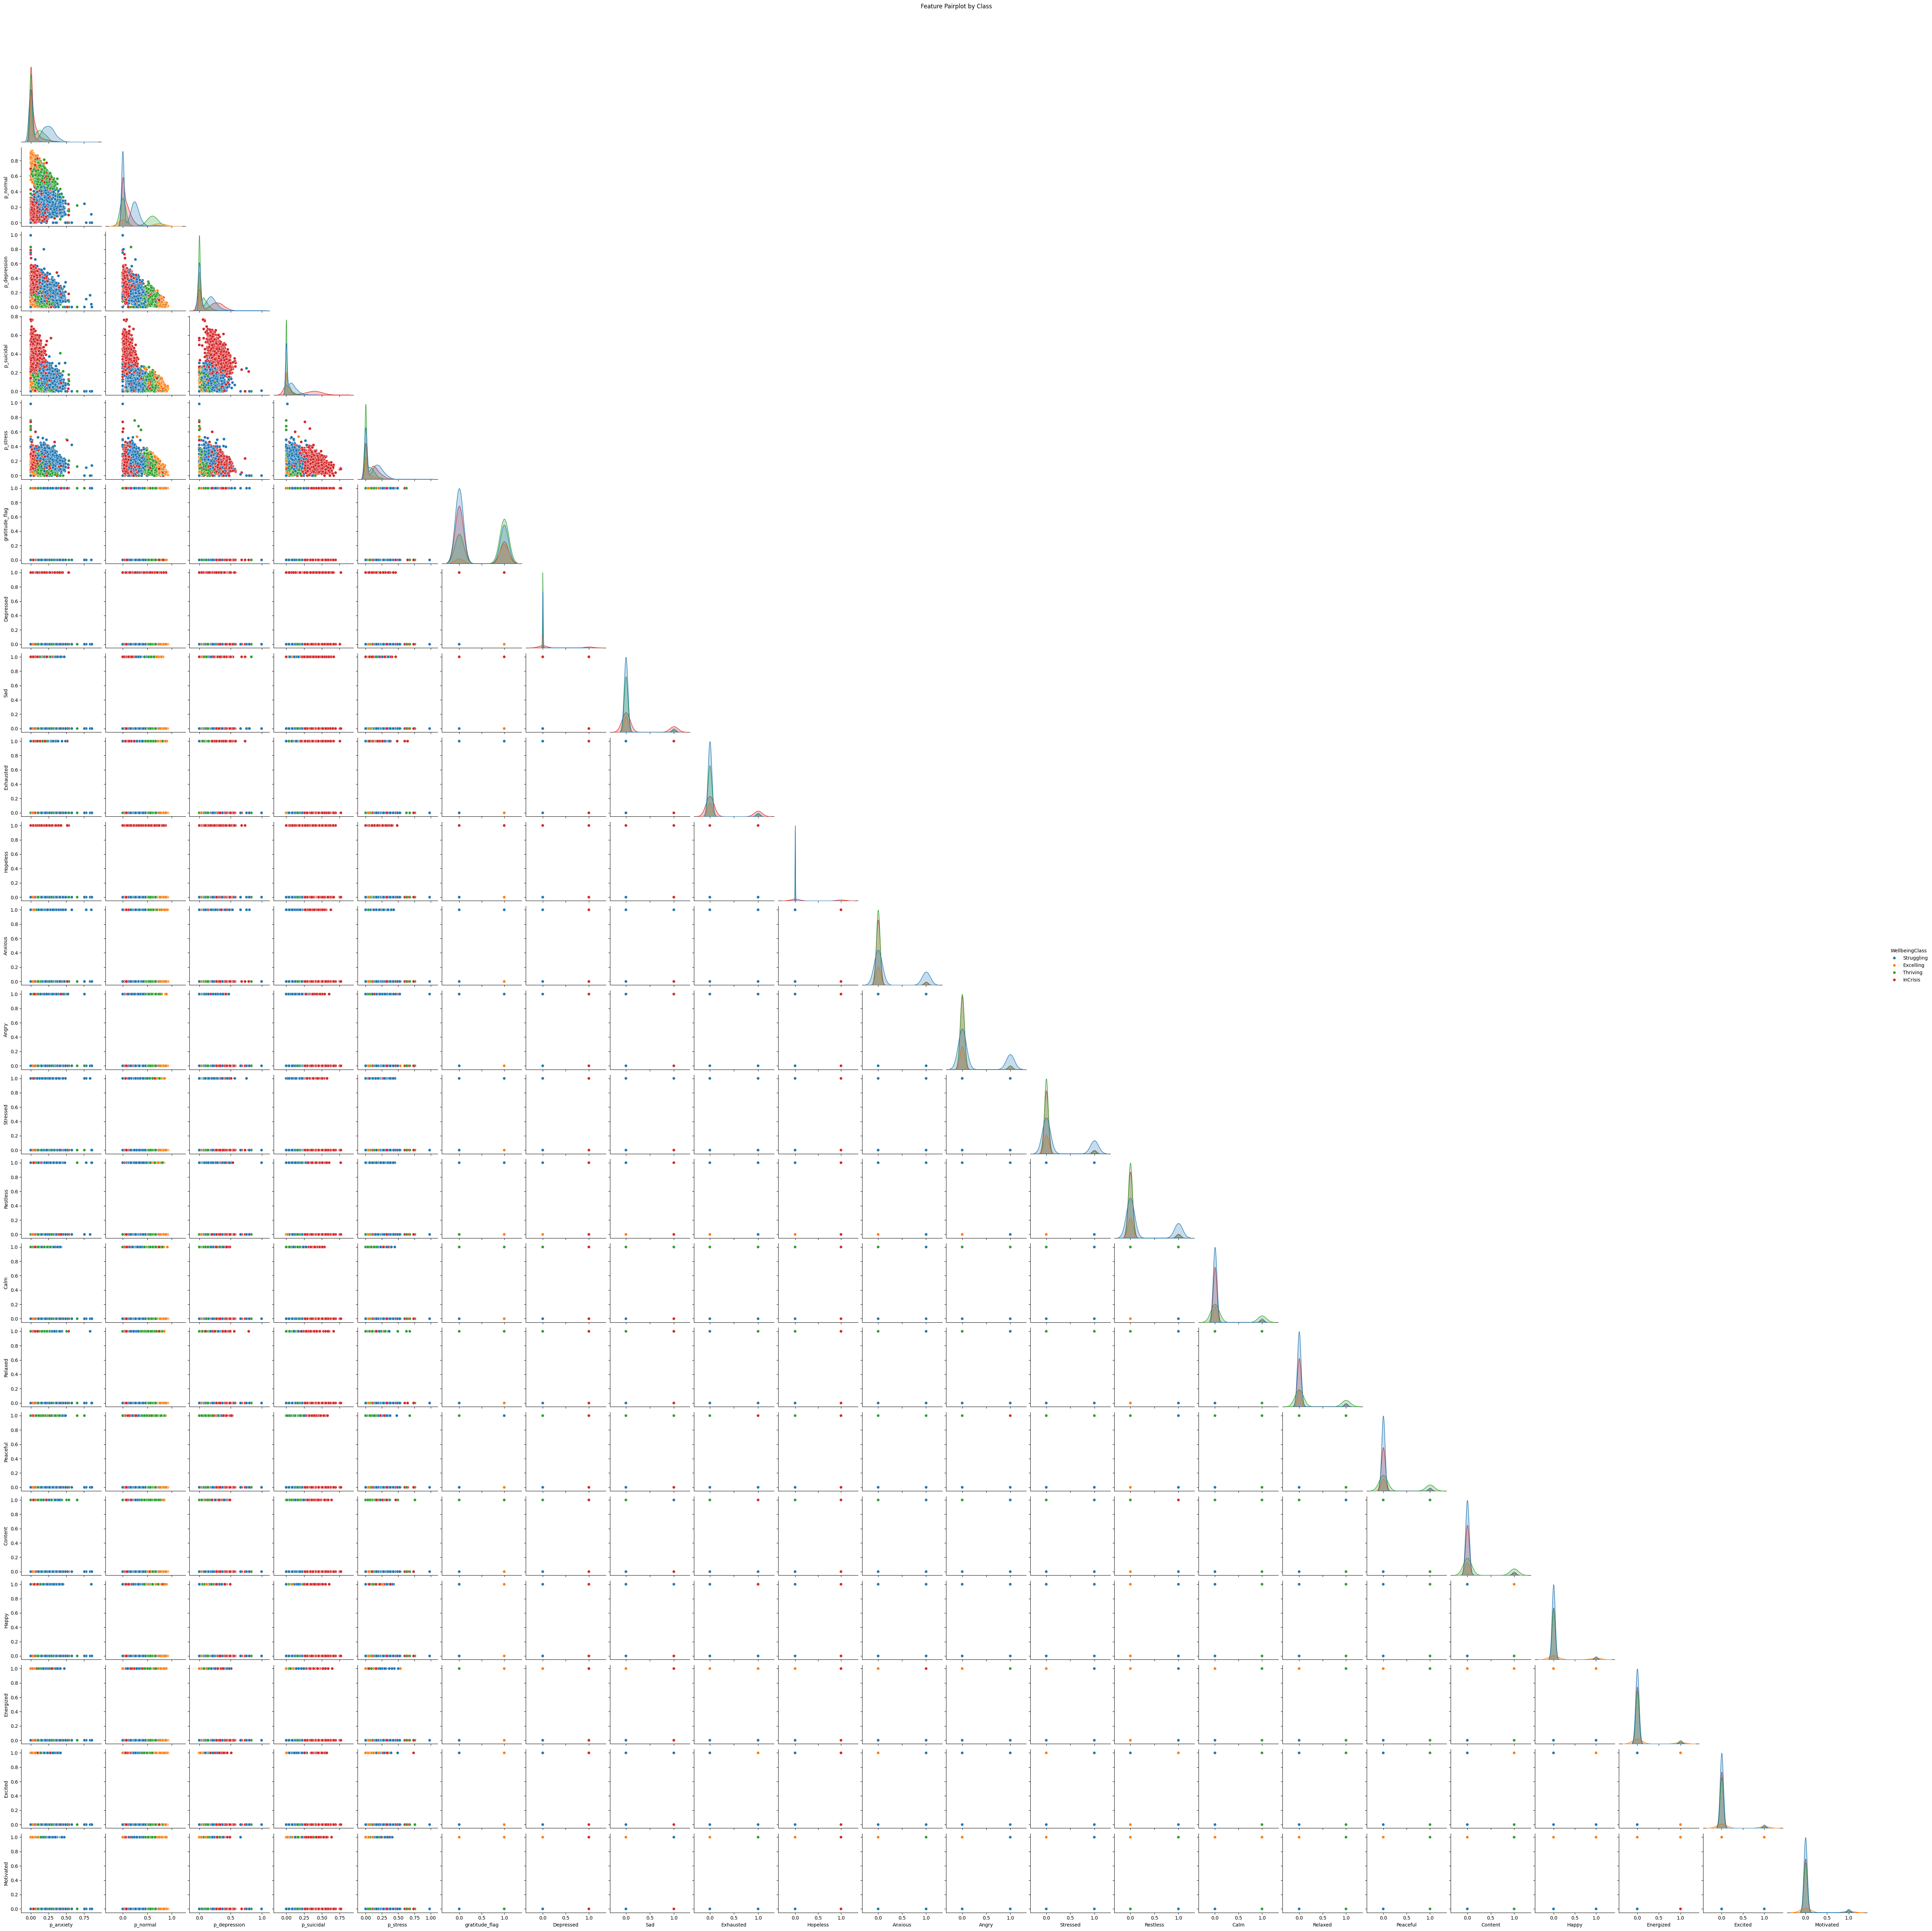

In [9]:
sns.pairplot(df[feature_cols + [target_col]], hue=target_col, diag_kind="kde", corner=True)
plt.suptitle("Feature Pairplot by Class", y=1.02)
plt.show()

### **7. PCA Visualization (2D Projection)**

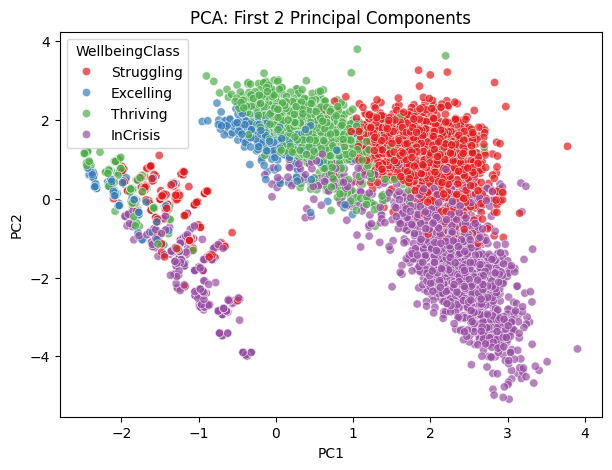

In [10]:
X_scaled = StandardScaler().fit_transform(df[feature_cols])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df[target_col] = df[target_col]

plt.figure(figsize=(7,5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue=target_col, alpha=0.7, palette="Set1")
plt.title("PCA: First 2 Principal Components")
plt.show()

## Data Pre-processing


Before dropping:
p_anxiety         0
p_normal          0
p_depression      0
p_suicidal        0
p_stress          0
gratitude_flag    0
Depressed         0
Sad               0
Exhausted         0
Hopeless          0
Anxious           0
Angry             0
Stressed          0
Restless          0
Calm              0
Relaxed           0
Peaceful          0
Content           0
Happy             0
Energized         0
Excited           0
Motivated         0
dtype: int64

After dropping:
p_anxiety         0
p_normal          0
p_depression      0
p_suicidal        0
p_stress          0
gratitude_flag    0
Depressed         0
Sad               0
Exhausted         0
Hopeless          0
Anxious           0
Angry             0
Stressed          0
Restless          0
Calm              0
Relaxed           0
Peaceful          0
Content           0
Happy             0
Energized         0
Excited           0
Motivated         0
dtype: int64


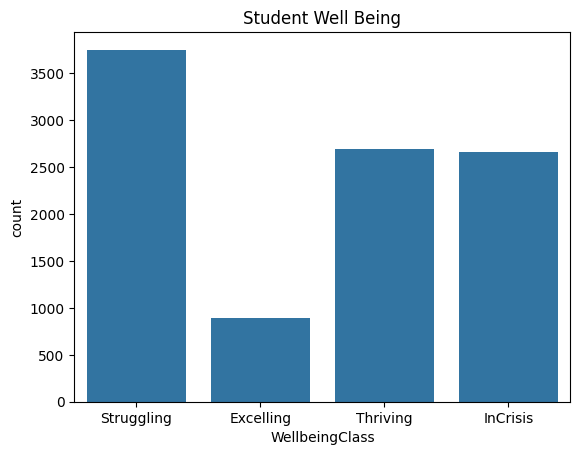

In [11]:
# Check for missing values
print("Before dropping:")
print(df[feature_cols].isna().sum())


# Drop the missing values
df = df.dropna()

# Check if missing values were dropped
print("\nAfter dropping:")
print(df[feature_cols].isna().sum())

# Class distribution
sns.countplot(x=target_col, data=df)
plt.title('Student Well Being')
plt.show()

In [12]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Encode categorical features before splitting
X_encoded = pd.get_dummies(X)

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

print("Training set features dtype:\n", X_train.dtypes.unique())  # Should show only numeric types

Training set features dtype:
 [dtype('float64') dtype('int64')]


## Model training


In [13]:
rf_pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

# Param grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['sqrt', 'log2']
}

# GridSearchCV setup
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit on original (imbalanced) training data
grid_search.fit(X_train, y_train)

# Save best model
best_model = grid_search.best_estimator_
joblib.dump(best_model, MODEL_PATH)

print("✅ Best Parameters:", grid_search.best_params_)

✅ Best Parameters: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


## Model Evaluation


✅ Cross-Validation Results Summary:



,mean_test_score,std_test_score,params
0,0.871883,0.002614,"{'classifier__max_depth': None, 'classifier__m..."
1,0.871883,0.002614,"{'classifier__max_depth': None, 'classifier__m..."
2,0.871883,0.002614,"{'classifier__max_depth': None, 'classifier__m..."
3,0.871883,0.002614,"{'classifier__max_depth': None, 'classifier__m..."
4,0.871883,0.002614,"{'classifier__max_depth': None, 'classifier__m..."
...,...,...,...
187,0.715964,0.015751,"{'classifier__max_depth': 3, 'classifier__max_..."
188,0.715964,0.015751,"{'classifier__max_depth': 3, 'classifier__max_..."
189,0.715964,0.015751,"{'classifier__max_depth': 3, 'classifier__max_..."
190,0.715964,0.015751,"{'classifier__max_depth': 3, 'classifier__max_..."



📊 Classification Report (Test Set):



,precision,recall,f1-score,support
Excelling,0.777,0.685,0.728,178.000
InCrisis,0.938,0.936,0.937,533.000
Struggling,0.877,0.891,0.884,750.000
Thriving,0.852,0.868,0.860,539.000
accuracy,0.878,0.878,0.878,0.878
macro avg,0.861,0.845,0.852,2000.000
weighted avg,0.878,0.878,0.878,2000.000



⚖️ Balanced Accuracy: 0.8451

🔎 Confusion Matrix:



,Pred_Excelling,Pred_InCrisis,Pred_Struggling,Pred_Thriving
True_Excelling,122,4,28,24
True_InCrisis,2,499,22,10
True_Struggling,15,20,668,47
True_Thriving,18,9,44,468


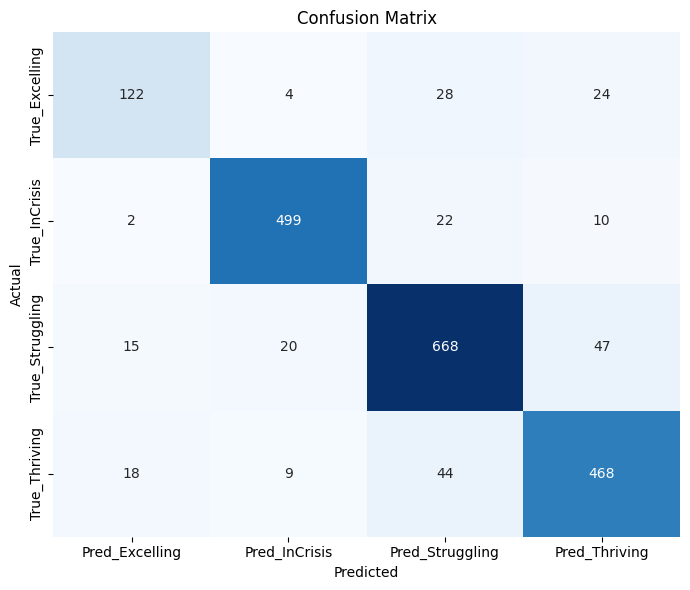


🌀 Classification Report (Shuffled Labels Baseline):



,precision,recall,f1-score,support
Excelling,0.076,0.118,0.093,178.000
InCrisis,0.227,0.184,0.203,533.000
Struggling,0.416,0.465,0.440,750.000
Thriving,0.268,0.226,0.245,539.000
accuracy,0.295,0.295,0.295,0.295
macro avg,0.247,0.248,0.245,2000.000
weighted avg,0.296,0.295,0.293,2000.000


In [14]:
# --- Cross-Validation Results ---
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_summary = cv_results_df[['mean_test_score', 'std_test_score', 'params']] \
    .sort_values(by='mean_test_score', ascending=False) \
    .reset_index(drop=True)

print("\n✅ Cross-Validation Results Summary:\n")
display(cv_summary)

# --- Predictions on Test Set ---
y_pred = grid_search.predict(X_test)

# Decode labels back to class names
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)
class_names = le.classes_

# --- Classification Report ---
report_dict = classification_report(
    y_test_labels, y_pred_labels, labels=class_names,
    output_dict=True, zero_division=0
)
report_df = pd.DataFrame(report_dict).T

print("\n📊 Classification Report (Test Set):\n")
display(report_df.round(3))

# --- Balanced Accuracy ---
bal_acc = balanced_accuracy_score(y_test_labels, y_pred_labels)
print(f"\n⚖️ Balanced Accuracy: {bal_acc:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=class_names)

cm_df = pd.DataFrame(
    cm, index=[f"True_{cls}" for cls in class_names],
    columns=[f"Pred_{cls}" for cls in class_names]
)

print("\n🔎 Confusion Matrix:\n")
display(cm_df)

plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- Shuffled Labels Baseline ---
from sklearn.utils import shuffle
baseline_model = RandomForestClassifier(class_weight='balanced', random_state=42)

y_shuffled = shuffle(y_train, random_state=42)
baseline_model.fit(X_train, y_shuffled)
y_pred_shuffled = baseline_model.predict(X_test)

y_pred_shuffled_labels = le.inverse_transform(y_pred_shuffled)

baseline_report_dict = classification_report(
    y_test_labels, y_pred_shuffled_labels,
    labels=class_names, output_dict=True, zero_division=0
)
baseline_report_df = pd.DataFrame(baseline_report_dict).T

print("\n🌀 Classification Report (Shuffled Labels Baseline):\n")
display(baseline_report_df.round(3))
